In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
import csv
import types
from collections import defaultdict

import sys
sys.path.insert(0,'/scratch/Documents/Conformity2019/')
import two_point_tools as tp
import my_functions as mf
import cosmic_distances as cosmo
from galaxy_sample import *

from sklearn import metrics

import time
from joblib import dump, load

In [2]:
plt.rcParams['font.size']=15

In [3]:
BAS = lambda x: np.sqrt( x[0]**2 - (x[1]**2 + x[2]**2) )

In [4]:
AM_redshift_bins = np.arange(0.02,0.09,0.01)
AM_src = 'data/LGalaxies/'

In [5]:
sample_collection = namedtuple('sample_collection',['sample','TrueGroups','GroupIDs','Groups','AM'])

In [6]:
src = 'data/LGalaxies/{}/'

sample_collections = []
for pnum in range(8):
    data = load( src.format(pnum)+'data')
    pairs = load( src.format(pnum)+'pairs')
    separations = load( src.format(pnum)+'separations')
    
    part = galaxy_sample(data)
    part.define_pairs( pair_list(pairs,separations,parent=part) )

    part.define_subsample( 'full', np.ones(part.count,).astype('bool') )

    pickle = load(src.format(pnum)+'corrfuncs'.format(pnum))
    for name,p in pickle.items():
        cf = corrfunc(*p['config'].values())
        cf.selection = p['selection']
        cf.results = p['results']
        cf.errorbars = p['errorbars']
        cf.stdev = p['stdev']
        cf.parent = part
        part.corrfuncs[name] = cf
    
    TrueGroups = dict()
    for idx,GrNr in enumerate(part.data['FOFCentralGal']):
        if GrNr not in TrueGroups:
            TrueGroups[GrNr] = [idx]
        else:
            TrueGroups[GrNr].append(idx)

    Groups = dict()
    for idx,GrNr in enumerate(part.data['ObsGrNr']):
        if GrNr not in Groups:
            Groups[GrNr] = [idx]
        else:
            Groups[GrNr].append(idx)

    
    AM = halo_mass_model.RedshiftDependentAbundanceMatching(src=AM_src, SHAM=False, redshift_bins=AM_redshift_bins)
    
    collection = sample_collection(part,TrueGroups,part.data['ObsGrNr'],Groups,AM)
    
    sample_collections.append(collection)

In [7]:
src = 'data/SDSS/'

data = load( src+'data')
pairs = load( src+'pairs')
separations = load( src+'separations')

sdss = galaxy_sample( data )
sdss.define_pairs( pair_list(pairs,separations,parent=sdss) )

sdss.define_subsample( 'full', np.ones(sdss.count,).astype('bool') )
#fq = mf.smooth2d(sdss.data['mstar'],sdss.data['density'],sdss.data['q'],np.mean,0.1,normalize=True)
#sdss.add_field( 'Delta_md', sdss.data['q']-fq)

pickle = load(src+'corrfuncs')
for name,p in pickle.items():
    cf = corrfunc(*p['config'].values())
    cf.selection = p['selection']
    cf.results = p['results']
    cf.errorbars = p['errorbars']
    cf.parent = sdss
    sdss.corrfuncs[name] = cf

(array([ 1136., 10234., 20418., 18069.,  6197.,  3800., 18321., 18070.,
         8882.,  1227.]),
 array([-0.95652174, -0.76086957, -0.56521739, -0.36956522, -0.17391304,
         0.02173913,  0.2173913 ,  0.41304348,  0.60869565,  0.80434783,
         1.        ]),
 <a list of 10 Patch objects>)

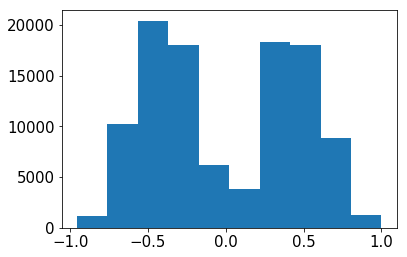

In [14]:
plt.hist(sdss.data['Delta_md'])

In [15]:
np.var(sdss.data['Delta_md'])

0.21314366762588313

In [16]:
0.04/np.var(sdss.data['Delta_md'])

0.18766684671209344

# Group findger metrics

In [8]:
BAS_list = [ BAS(MyEvaluate(col.sample,col.sample.data['FOFCentralGal'],col.sample.data['ObsGrNr'])) 
               for col in sample_collections ]
AR_list = [ metrics.adjusted_rand_score( col.sample.data['FOFCentralGal'], col.sample.data['ObsGrNr']) 
              for col in sample_collections ]
FM_list = [ metrics.fowlkes_mallows_score( col.sample.data['FOFCentralGal'], col.sample.data['ObsGrNr']) 
               for col in sample_collections ]

pairwise_statistics = {'balanced_accuracy': ( np.mean(BAS_list), np.std(BAS_list) ), 
                       'adjusted_rand': ( np.mean(AR_list), np.std(AR_list) ),
                       'fowlkes_mallow': ( np.mean(FM_list), np.std(FM_list) )}

In [9]:
pairwise_statistics

{'balanced_accuracy': (0.7476142785879892, 0.012177668227249139),
 'adjusted_rand': (0.6725322242621359, 0.018203840165513113),
 'fowlkes_mallow': (0.6743458562059805, 0.017866154215745084)}

In [10]:
for collection in sample_collections:
    
    sample=collection.sample
    gc = group_catalogue(sample,AM=collection.AM)
    
    t=0.5
    
    print(gc.two_way_match_fraction(
                base='true', threshold=t, 
                binning=['mass',[10,15.5]])
    )
    
    print(gc.two_way_match_fraction(
                base='obs', threshold=t, 
                binning=['mass',[10,15.5]])
    )
    
    
    print(gc.two_way_match_fraction(
                base='true', threshold=t, 
                binning=['richness',(0,100)])
    )
    
    print(gc.two_way_match_fraction(
                base='obs', threshold=t, 
                binning=['richness',(0,100)])
    )

    print()

(array([12.75]), [0.8706072612598044])
(array([12.75]), [0.874423364303814])
(array([50.]), [0.8705800524085278])
(array([50.]), [0.8744191336561271])

(array([12.75]), [0.8709059807598751])
(array([12.75]), [0.8673960612691466])
(array([50.]), [0.8709267281974007])
(array([50.]), [0.867407720088176])

(array([12.75]), [0.8757698743280288])
(array([12.75]), [0.8813392329326621])
(array([50.]), [0.8757633485854683])
(array([50.]), [0.8813632209858625])

(array([12.75]), [0.8657063894980324])
(array([12.75]), [0.8601895380941721])
(array([50.]), [0.8657041555241729])
(array([50.]), [0.8602012480965036])

(array([12.75]), [0.867648024156492])
(array([12.75]), [0.8739297166848491])
(array([50.]), [0.8676253324140648])
(array([50.]), [0.8739231799467584])

(array([12.75]), [0.8699753963469278])
(array([12.75]), [0.8691681588800261])
(array([50.]), [0.8699698476081819])
(array([50.]), [0.8691744015632633])

(array([12.75]), [0.8677357657790201])
(array([12.75]), [0.8769825535289453])
(array(

In [ ]:
truemass=[0.8702349741902916,0.8693981260917898,0.8769708681753328,0.8649651689836644,
 0.8701795212765957,0.8685954795519322,0.8686881343190076]

obsmass=[0.8735288348371910,0.8672084145163079,0.8794283851336666,0.8607234751021644,
 0.8683608134558604,0.8748998531179063,0.8655835947375814]

truerich=[0.8702074986155901,0.8694008513882712,0.8769825499476137,0.8649647806970836,
 0.8701760803418519,0.8685981370371598,0.8686770580402601]

obsrich=[0.8735570162529841,0.8672180760881621,0.8794565217391305,0.8607506775478069,
 0.8683922349427576,0.8749582581980899,0.8655947549172651]

print(np.mean(truemass),np.std(truemass))
print(np.mean(obsmass),np.std(obsmass))
print(np.mean(truerich),np.std(truerich))
print(np.mean(obsrich),np.std(obsrich))

In [24]:
for collection in sample_collections:
    
    sample=collection.sample
    gc = group_catalogue(sample,AM=collection.AM)
    
    foo = gc.completeness_purity( base='true', threshold=0.5,
                                  binning=[None,[0,100]])
    
    print(np.mean(foo[1],axis=2))

[[0.95249257]
 [0.05382667]
 [0.03901855]]
[[0.95197615]
 [0.05344129]
 [0.03875181]]
[[0.95550541]
 [0.05530306]
 [0.0397408 ]]
[[0.94829504]
 [0.05620312]
 [0.04089331]]
[[0.95229106]
 [0.05777803]
 [0.04158262]]


In [ ]:
foo=[[[0.95174936],
 [0.05439563],
 [0.03924281]],
[[0.95154898],
 [0.05200952],
 [0.03768032]],
[[0.95499134],
 [0.05380754],
 [0.03861667]],
[[0.94769042],
 [0.05517414],
 [0.04020451]],
[[0.9522518 ],
 [0.05719418],
 [0.04123999]],
[[0.9522343 ],
 [0.05688475],
 [0.04131036]],
[[0.95114148],
 [0.05718956],
 [0.04140179]]]

print(np.mean(foo,axis=0),np.std(foo,axis=0))

In [11]:
thresholds = np.linspace(0.5,0.9,5)

two_way_match_truemass = defaultdict(list)
two_way_match_obsmass = defaultdict(list)
two_way_match_truerichness = defaultdict(list)
two_way_match_obsrichness = defaultdict(list)
c0_ensemble = defaultdict(list)
c1_ensemble = defaultdict(list)
c2_ensemble = defaultdict(list)
c0_means = defaultdict(list)
c1_means = defaultdict(list)
c2_means = defaultdict(list)

iou_threshold = 0.5

for collection in sample_collections:
    
    sample=collection.sample
    gc = group_catalogue(sample,AM=collection.AM)
    
    for t in thresholds:
        two_way_match_truemass[t].append(
            gc.two_way_match_fraction(base='true', 
                                      threshold=t, 
                                      binning=['mass',np.linspace(10,15.5,25)])
        )
        
    for t in thresholds:
        two_way_match_obsmass[t].append(
            gc.two_way_match_fraction(base='obs', 
                                      threshold=t, 
                                      binning=['mass',np.linspace(10,15.5,25)])
        )
    
    for t in thresholds:
        two_way_match_truerichness[t].append(
            gc.two_way_match_fraction(base='true', 
                                      threshold=t, 
                                      binning=['richness',np.linspace(0,100,11)])
        )
        
    for t in thresholds:
        two_way_match_obsrichness[t].append(
            gc.two_way_match_fraction(base='obs', 
                                      threshold=t, 
                                      binning=['richness',np.linspace(0,100,11)])
        )
    
    foo = gc.completeness_purity( base='true', threshold=iou_threshold,
                                  binning=[None,np.arange(0,80,20)])
    for bin_,c0,c1,c2 in zip(foo[0],*foo[1]):
        y,x=np.histogram(c0,density=True, bins=np.linspace(0.5,1.0,11))
        c0_ensemble[bin_].append((x,y))
        c0_means[bin_].append(np.mean(c0))

        y,x=np.histogram(c1,density=True, bins=np.linspace(0.,1.0,11))
        c1_ensemble[bin_].append((x,y))
        c1_means[bin_].append(np.mean(c1))

        y,x=np.histogram(c2,density=True, bins=np.linspace(0.,0.5,11))
        c2_ensemble[bin_].append((x,y))
        c2_means[bin_].append(np.mean(c2))

/scratch/Documents/Conformity2019/env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/scratch/Documents/Conformity2019/env/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [12]:
len(sample_collections)

8

Text(0.5, 0, 'Observed halo mass [$\\rm{log}_{10}(M_{H}/M_{\\odot})$]')

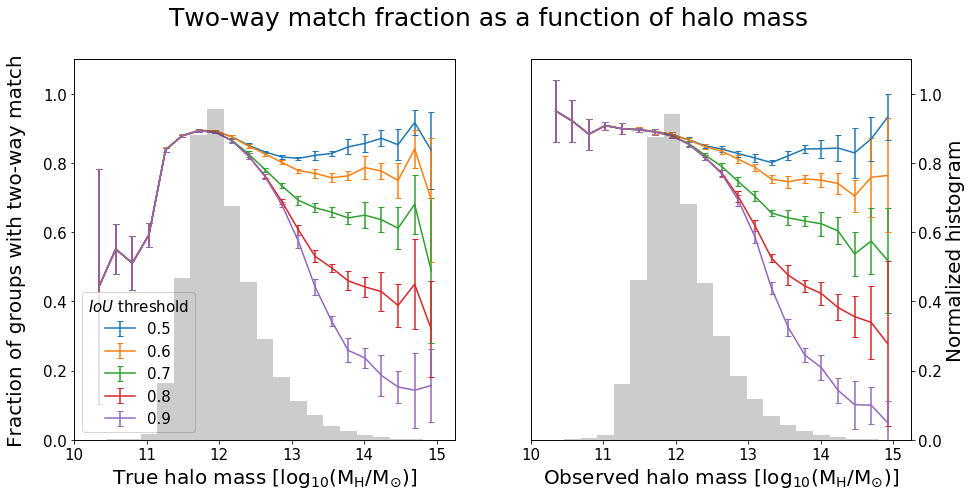

In [12]:
fig1,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7)) 

over = fig1.add_subplot(111)
over.set_frame_on(False)
over.set_xticks([])
over.set_yticks([])
over.set_title('Two-way match fraction as a function of halo mass \n',
               fontsize=25)
over.set_ylabel('Fraction of groups with two-way match\n\n',fontsize=20)

for t in thresholds:
    fracs = [x[1] for x in two_way_match_truemass[t]]
    ax1.errorbar( two_way_match_truemass[t][0][0], np.mean(fracs,axis=0), np.std(fracs,axis=0),
                  capsize=3, label='{0:.1f}'.format(t))
    
    fracs = [x[1] for x in two_way_match_obsmass[t]]
    ax2.errorbar( two_way_match_obsmass[t][0][0], np.mean(fracs,axis=0), np.std(fracs,axis=0),
                  capsize=3)

ax1t = ax1.twinx()
ax1t.hist(gc.TrueMass,bins=np.linspace(10,15.5,25),density=True,
          facecolor='k',alpha=0.2)
ax1t.set_yticks([])

ax2.set_yticks([])
ax2t = ax2.twinx()
ax2t.hist(gc.ObsMass,bins=np.linspace(10,15.5,25),density=True,
          facecolor='k',alpha=0.2)
ax2t.set_ylabel('Normalized histogram',fontsize=20)

ax1.legend(title="$IoU$ threshold",loc="lower left")
ax1.axis([10,15.25,0,1.1])
ax1t.axis([10,15.25,0,1.1])
ax1.set_xlabel('True halo mass [$\\rm{log}_{10}(M_{H}/M_{\\odot})$]',fontsize=20)
ax2.axis([10,15.25,0,1.1])
ax2t.axis([10,15.25,0,1.1])
ax2.set_xlabel('Observed halo mass [$\\rm{log}_{10}(M_{H}/M_{\\odot})$]',fontsize=20)

In [15]:
len(fracs)

8

/scratch/Documents/Conformity2019/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:1718: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  self.set_ylim([v[2], v[3]], emit=emit, auto=False)


Text(0.5, 0, 'Observed group richness')

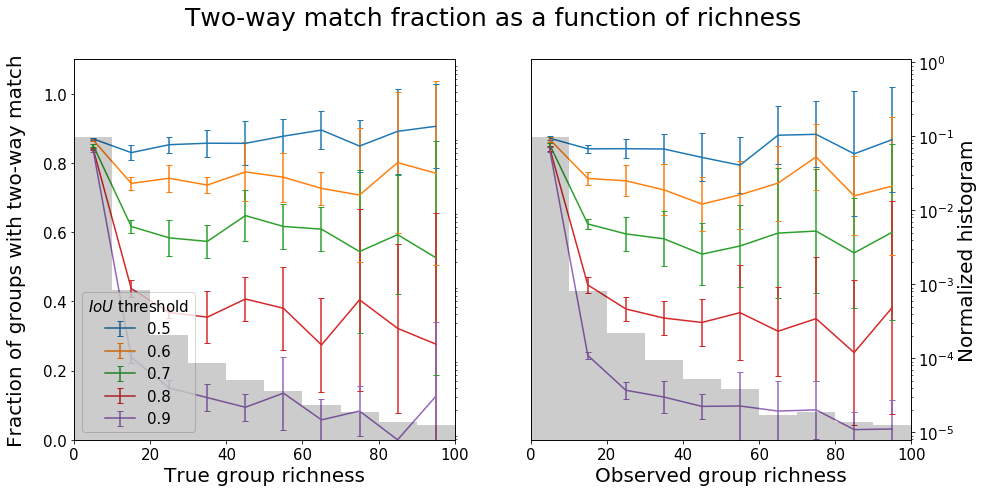

In [13]:
fig2,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))

over = fig2.add_subplot(111)
over.set_frame_on(False)
over.set_xticks([])
over.set_yticks([])
over.set_title('Two-way match fraction as a function of richness\n',fontsize=25)
over.set_ylabel('Fraction of groups with two-way match\n\n',fontsize=20)

for t in thresholds:
    fracs = [x[1] for x in two_way_match_truerichness[t]]
    ax1.errorbar( two_way_match_truerichness[t][0][0], np.mean(fracs,axis=0), np.std(fracs,axis=0),
                  capsize=3, label='{0:.1f}'.format(t))

    
    fracs = [x[1] for x in two_way_match_obsrichness[t]]
    ax2.errorbar( two_way_match_obsrichness[t][0][0], np.mean(fracs,axis=0), np.std(fracs,axis=0),
                  capsize=3)

ax1t = ax1.twinx()
ax1t.hist(gc.TrueRich,bins=np.linspace(0,100,11),density=True,
          facecolor='k',alpha=0.2)
ax1t.set_yscale('log')
ax1t.set_yticks([])

ax2.set_yticks([])
ax2t = ax2.twinx()
ax2t.hist(gc.ObsRich,bins=np.linspace(0,100,11),density=True,
          facecolor='k',alpha=0.2)
ax2t.set_yscale('log')
ax2t.set_ylabel('Normalized histogram',fontsize=20)

#ax2t.tick_params(direction='out', length=6, width=2, colors='r',
#                   grid_color='r', grid_alpha=0.5)

ax1.axis([0,100,0,1.1])
ax1t.axis([0,100,0,1.1])
ax2.axis([0,100,0,1.1])
ax2t.axis([0,100,0,1.1])

ax1.legend(title="$IoU$ threshold",loc="lower left")
ax1.set_xlabel('True group richness',fontsize=20)
ax2.set_xlabel('Observed group richness',fontsize=20)

Text(0.5, 0, 'Contamination\n(#Interlopers/Obs. group size)')

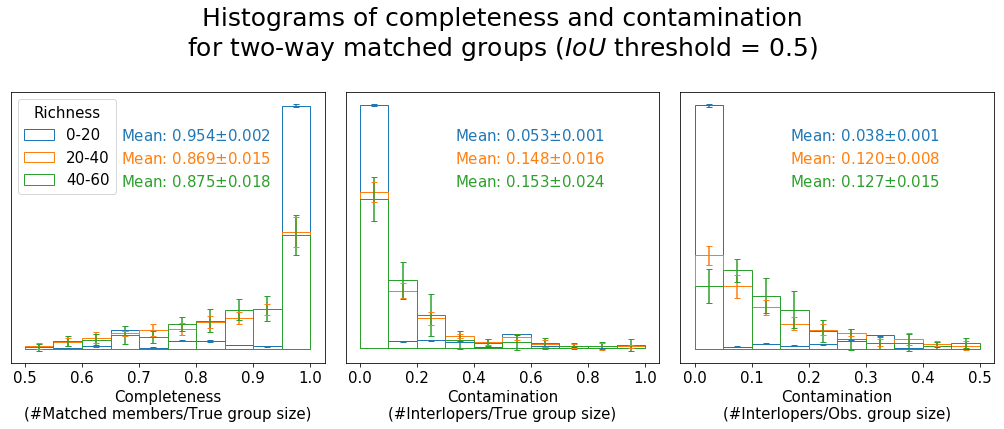

In [14]:
fig3, axes = plt.subplots(1,3,figsize=(17,5))

shift=0
for bin_,color in zip(c0_ensemble.keys(), plt.rcParams['axes.prop_cycle']):
    
    color = color['color']
    
    for ensemble,means,ax in zip((c0_ensemble,c1_ensemble,c2_ensemble),
                                 (c0_means,c1_means,c2_means),
                                 axes):
        width = np.diff( ensemble[bin_][0][0] )[0]
        x = ensemble[bin_][0][0][:-1] + width/2
        y = [v[1] for v in ensemble[bin_]]
        ax.bar( x, height = np.mean(y,axis=0), width = width,
                     yerr=np.std(y,axis=0), capsize=3, ecolor=color,
                     edgecolor=color, color='None')
        ax.text( 0.35, 0.82+shift, 
                  'Mean: {0:.3f}$\pm${1:.3f}'.format(np.mean(means[bin_]),np.std(means[bin_])),
                  color=color,transform = ax.transAxes)
        ax.set_yticks([])
        
        x0,y0,w,h=ax.get_position().bounds
        ax.set_position([x0,y0,w*1.04,h])
        
    shift-=0.085

axes[0].legend(list( '{}-{}'.format(a,b) for a,b in c0_ensemble.keys() ),
                 title="Richness",loc='upper left')
axes[1].set_title('Histograms of completeness and contamination\n'+
               'for two-way matched groups ($IoU$ threshold = {})\n'.format(iou_threshold),
               fontsize=25)
axes[0].set_xlabel('Completeness\n(#Matched members/True group size)')
axes[1].set_xlabel('Contamination\n(#Interlopers/True group size)')
axes[2].set_xlabel('Contamination\n(#Interlopers/Obs. group size)')

In [17]:
dump(pairwise_statistics,'figures/pairwise_statistics')
fig1.savefig('figures/fig1.png', bbox_inches = 'tight')
fig2.savefig('figures/fig2.png', bbox_inches = 'tight')
fig3.savefig('figures/fig3.png', bbox_inches = 'tight')

# Conformity figures

In [15]:
lg_average_corrfuncs = dict()
for name in ('true_same_halo', 'obs_same_halo', 'true_diff_halo', 'obs_diff_halo',
             'true_same_halo_unwtd', 'obs_same_halo_unwtd', 'true_diff_halo_unwtd', 'obs_diff_halo_unwtd'):
    
    cf = corrfunc('Delta_md', sample='dummy', pairs='dummy', weighted=True)
    
    cf.results = np.mean([c.sample.corrfuncs[name].results 
                          for c in sample_collections],axis=0)
    cf.stdev = np.std([c.sample.corrfuncs[name].results 
                       for  c in sample_collections],axis=0)

    lg_average_corrfuncs[name] = cf

/scratch/Documents/Conformity2019/env/lib/python3.6/site-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.collections.LineCollection object at 0x7fa5dace8048> has a label of '_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/scratch/Documents/Conformity2019/env/lib/python3.6/site-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.collections.LineCollection object at 0x7fa5dacb2550> has a label of '_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/scratch/Documents/Conformity2019/env/lib/python3.6/site-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.collections.LineCollection object at 0x7fa5dac75080> has a label of '_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/scratch/Documents/Conformity2019/env/lib/python3.6/site-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.collections.Li

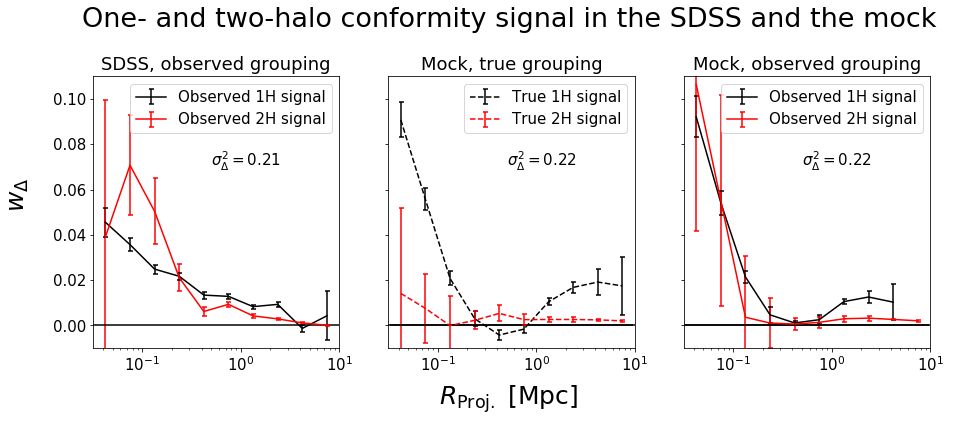

In [31]:
fig4 = plt.figure(figsize=(15,5))

pos = [0.1,0.1,0.82,0.9]

over = fig4.add_subplot(111)
over.set_position(pos)
for spine in over.spines.values():
    spine.set_color('none')
over.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
over.set_xlabel('$R_{\\rm{Proj.}}$ [Mpc]',fontsize=25)
over.set_ylabel('$w_{\\Delta}$',fontsize=25)
over.set_title('One- and two-halo conformity signal in the SDSS and the mock',fontsize=27)

ax = fig4.add_subplot(1,3,1)
sdss.corrfuncs['obs_same_halo'].plot(ax,('errorbar','errorbars'),color='k',capsize=2.5,capthick=1.5)
sdss.corrfuncs['obs_diff_halo'].plot(ax,('errorbar','errorbars'),color='r',capsize=2.5,capthick=1.5)
ax.text(0.5,0.07, '$\\sigma_{\\Delta}^2=$'+'{0:.2f}'.format(np.var(sdss.data['Delta_md'])) )
ax.set_xscale('log')
ax.set_ylim([-0.02,0.1])
ax.hlines(0,10**-1.5,10**1.0)
ax.axis([10**-1.5,10**1,-0.01,0.11])
ax.set_title('SDSS, observed grouping')
ax.legend(('_','Observed 1H signal','Observed 2H signal'))

ax = fig4.add_subplot(1,3,2)
lg_average_corrfuncs['true_same_halo'].plot(ax,('errorbar','stdev'),fmt='k--',capsize=2.5,capthick=1.5)
lg_average_corrfuncs['true_diff_halo'].plot(ax,('errorbar','stdev'),fmt='r--',capsize=2.5,capthick=1.5)
ax.text(0.5,0.07, 
        '$\\sigma_{\\Delta}^2=$'+'{0:.2f}'.format(
            np.mean( [np.var(c.sample.data['Delta_md']) for c in sample_collections] )
        ))
ax.set_xscale('log')
ax.set_ylim([-0.02,0.1])
ax.hlines(0,*ax.get_xlim())
ax.set_yticklabels('')
ax.hlines(0,10**-1.5,10**1.0)
ax.axis([10**-1.5,10**1,-0.01,0.11])
ax.set_title('Mock, true grouping')
ax.legend(('_','_','True 1H signal','True 2H signal'))

ax = fig4.add_subplot(1,3,3)
lg_average_corrfuncs['obs_same_halo'].plot(ax,('errorbar','stdev'),color='k',capsize=2.5,capthick=1.5)
lg_average_corrfuncs['obs_diff_halo'].plot(ax,('errorbar','stdev'),color='r',capsize=2.5,capthick=1.5)
ax.text(0.5,0.07, 
        '$\\sigma_{\\Delta}^2=$'+'{0:.2f}'.format(
            np.mean( [np.var(c.sample.data['Delta_md']) for c in sample_collections] )
        ))
ax.set_xscale('log')
ax.set_ylim([-0.02,0.1])
ax.hlines(0,*ax.get_xlim())
ax.set_yticklabels('')
ax.hlines(0,10**-1.5,10**1.0)
ax.axis([10**-1.5,10**1,-0.01,0.11])
ax.set_title('Mock, observed grouping')
ax.legend(('_','_','Observed 1H signal','Observed 2H signal'))

In [32]:
fig4.savefig('figures/fig4.png', bbox_inches='tight')

In [21]:
AnomCount = {'pairs':[],'pairs_percent':[],
             'galaxies':[],'galaxies_percent':[],
             'groups':[],'groups_percent':[]}

for c in sample_collections:
    part = c.sample
    sel = np.logical_and(part.pair_list.separations>4,
                         part.corrfuncs['true_same_halo'].selection)
    AnomCount['pairs'].append( np.sum(sel) )
    AnomCount['pairs_percent'].append( 100*np.sum(sel)/np.sum(part.pair_list.separations>4) )
    AnomCount['galaxies'].append( np.unique( part.pair_list.pairs[sel,:]).size )
    AnomCount['galaxies_percent'].append( 100*np.unique( part.pair_list.pairs[sel,:]).size/
                                  part.count )
    AnomCount['groups'].append( np.unique( part.pair_list.select(sel).get('FOFCentralGal') ).size )
    AnomCount['groups_percent'].append( 100*np.unique( part.pair_list.select(sel).get('FOFCentralGal') ).size/
                                np.unique( part.data.get('FOFCentralGal') ).size )
    
minmax = lambda x: (min(x),max(x))
for name,stat in AnomCount.items():
    print(name+': {0:.3f}-{1:.3f}'.format(*minmax(stat)))

pairs: 10888.000-47492.000
pairs_percent: 0.214-0.891
galaxies: 1769.000-2838.000
galaxies_percent: 1.814-2.605
groups: 65.000-99.000
groups_percent: 0.106-0.149


# Figure 2

In [34]:
for c in sample_collections:
    lg = c.sample
    #lg.define_subsample( 'full', np.ones(lg.count,).astype('bool') )
    for name in ('obs_diff_halo','same_correct','merge','diff_correct','frag'):
        cf = lg.corrfuncs[name]
        
        Selection1Mpc = np.logical_and( cf.selection, lg.pair_list.separations<1)
        
        cf.Fraction1Mpc = np.sum(Selection1Mpc)/np.sum(lg.pair_list.separations<1)
        cf.RprojHist = np.histogram( lg.pair_list.separations[cf.selection],
                                     bins=10**cf.config.bins.edges )[0]

In [35]:
AverageCfs = dict()
names = ('full_sample', 'true_same_halo', 'true_diff_halo', 'obs_same_halo', 'obs_diff_halo',
         'same_correct', 'merge', 'diff_correct', 'frag',
         'true_same_halo_unwtd', 'true_diff_halo_unwtd', 'obs_same_halo_unwtd', 'obs_diff_halo_unwtd',
         'same_correct_unwtd', 'merge_unwtd', 'diff_correct_unwtd', 'frag_unwtd',
        )
for name in names:
    AverageCfs[name] = corrfunc('Delta_md', sample='dummy', pairs='dummy', weighted=True)
    AverageCfs[name].results = np.mean([c.sample.corrfuncs[name].results for c in sample_collections],axis=0)
    AverageCfs[name].stdev = np.std([c.sample.corrfuncs[name].results for c in sample_collections],axis=0)

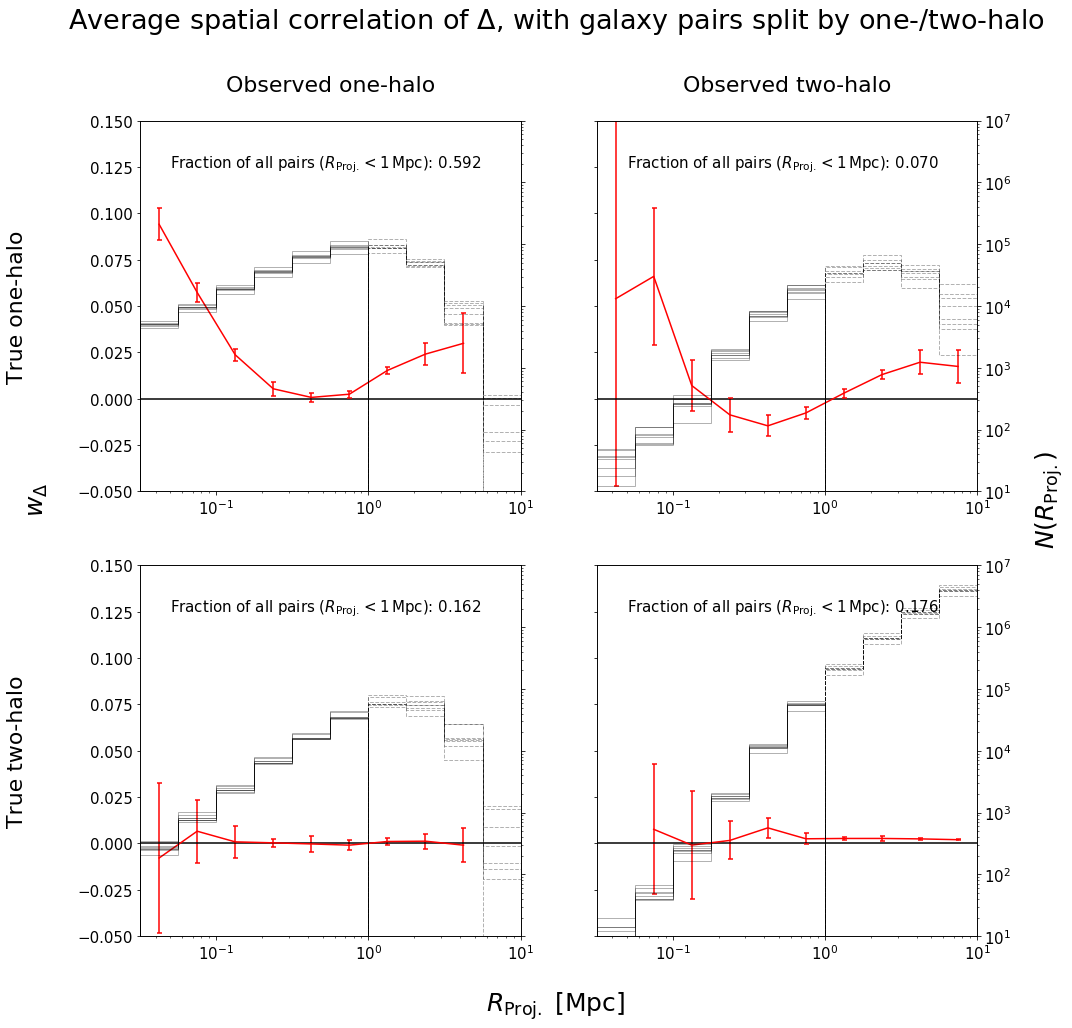

In [24]:
fig5 = plt.figure(figsize=(15,15))

pos = [0.1,0.1,0.82,0.86]

over = fig5.add_subplot(111)
over.set_position(pos)
for spine in over.spines.values():
    spine.set_color('none')
over.tick_params(color='none', labelcolor='none', top='off', bottom='off', left='off', right='off')
over.set_xlabel('$R_{\\rm{Proj.}}$ [Mpc]',fontsize=25)
over.set_ylabel('$w_{\\Delta}$\n',fontsize=25)
over.set_title('Average spatial correlation of $\Delta$, with galaxy pairs split by one-/two-halo',fontsize=27)

over2 = over.twinx()
over2.set_position(pos)
for spine in over2.spines.values():
    spine.set_color('none')
over2.tick_params(color='none', labelcolor='none', top='off', bottom='off', left='off', right='off')
over2.set_ylabel('$N(R_{\\rm{Proj.}})$',fontsize=25)


for i,name in enumerate(('same_correct','frag','merge','diff_correct')):
    
    ax=fig5.add_subplot(2,2,i+1)
    ax.margins(x=1,y=1)
    
    AverageCfs[name].plot(ax,('errorbar','stdev'),color='r',capsize=2.5,capthick=1.5)
    ax.set_xscale('log')
    ax.hlines(0,10**-1.5,10**1.0)
    ax.axis([10**-1.5,10**1,-0.05,0.15])

    ax.text( 0.05, 0.125,
             'Fraction of all pairs ($R_{\\rm{Proj.}}<1\,\\rm{Mpc}$): '+
             '{0:.3f}'.format( np.mean([ c.sample.corrfuncs[name].Fraction1Mpc 
                                        for c in sample_collections]) ),
             fontsize=15 )

    ax2 = ax.twinx()
    for c in sample_collections:
        part = c.sample
        ax2.hist(part.pair_list.separations[ part.corrfuncs[name].selection ], 
                 bins=10**part.corrfuncs[name].config.bins.edges[:-4],
                 histtype='step', color='k', alpha=0.3 )
        ax2.hist(part.pair_list.separations[ part.corrfuncs[name].selection ], 
                 bins=10**part.corrfuncs[name].config.bins.edges[-5:],
                 histtype='step', color='k', linestyle='--', alpha=0.3 )
    ax2.set_yscale('log')
    ax2.set_ylim([1e1,1e7])
    
    
    TrueCat = 'same' if i<=1 else 'diff'
    ObsCat = 'same' if i%2==0 else 'diff' 

    if TrueCat=='same':
        for c in sample_collections:
            part = c.sample
            #part.corrfuncs['true_same_halo'].plot(ax,('fill_between','stdev'), color='r', alpha=0.05)
            
        if ObsCat=='same':
            ax.set_title('Observed one-halo\n',fontsize=22)
            ax.set_ylabel('True one-halo\n\n',fontsize=22)
        elif ObsCat=='diff':
            ax.set_title('Observed two-halo\n',fontsize=22)
            
    elif TrueCat=='diff':
        for c in sample_collections:
            part = c.sample
            #part.corrfuncs['true_diff_halo'].plot(ax,('fill_between','stdev'), color='r', alpha=0.05)
            
        if ObsCat=='same':        
            ax.set_ylabel('True two-halo\n\n',fontsize=22)
            
    if ObsCat=='same':        
        ax2.set_yticklabels([])
    elif ObsCat=='diff':
        ax.set_yticklabels([])

In [25]:
fig5.savefig('figures/fig5.png', bbox_inches = 'tight')

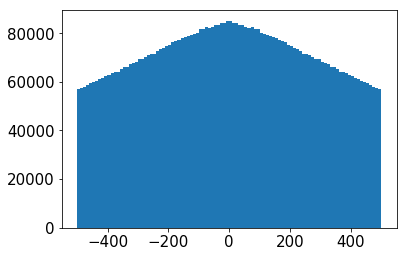

In [39]:
plt.hist( 
    np.diff( 3e5*sample_collections[0].sample.pair_list.get('redshift'), axis=1 
).reshape(sample_collections[0].sample.pair_list.count,), bins=100);

In [12]:
#unweighted
#for c in sample_collections:
#    part = c.sample
#    part.f2h_correct = part.corrfuncs['diff_correct'].RprojHist/part.corrfuncs['obs_diff_halo'].RprojHist
#    part.f2h_frag = part.corrfuncs['frag'].RprojHist/part.corrfuncs['obs_diff_halo'].RprojHist

#fig6 = plt.figure(figsize=(10,8))
#ax = fig6.add_subplot(111)
#ax.errorbar(
#            10**(sample_collections[0].sample.corrfuncs['obs_diff_halo'].config.bins.edges[:-1]+0.125),
#            np.mean([c.sample.f2h_correct for c in sample_collections],axis=0),
#            np.std([c.sample.f2h_correct for c in sample_collections],axis=0),
#            capsize=5,capthick=1.5
#)
#ax.errorbar(
#            10**(sample_collections[0].sample.corrfuncs['obs_diff_halo'].config.bins.edges[:-1]+0.125),
#            np.mean([c.sample.f2h_frag for c in sample_collections],axis=0),
#            np.std([c.sample.f2h_frag for c in sample_collections],axis=0),
#            capsize=5,capthick=1.5
#)
#ax.set_xscale('log')
#ax.legend(('$f_{\\rm{2H,Correct}}$','$f_{\\rm{2H,Fragment}}$'))
#ax.set_xlabel('$R_{\\rm{Proj.}}$ [Mpc]',fontsize=25)
#ax.set_ylabel('Fraction of two-halo pairs',fontsize=25)
#ax.set_title('Fraction of (in)correctly identified two-halo pairs,\n as a function of separation')

In [36]:
#weighted

for c in sample_collections:
    sum_of_weights = {'obs_diff_halo':[],'frag':[],'diff_correct':[]}
    
    part = c.sample
    
    config = part.corrfuncs['obs_diff_halo'].config
    selection = part.corrfuncs['obs_diff_halo'].selection
    edges = config.bins.edges
    
    P = part.pair_list.select(selection)

    if config.bins.scale == 'log':
        P.separations = np.log10(P.separations)
    mask = np.logical_and( edges[0]<P.separations, P.separations<edges[-1] )
    P = P.select(mask)
    P.sort(by='separation')

    weights = P.downweight()

    true_same_halo = np.equal(*(P.get('FOFCentralGal').T))
    true_diff_halo = np.logical_not(true_same_halo)

    obs_same_halo = np.equal(*(P.get('ObsGrNr').T))
    obs_diff_halo = np.logical_not(obs_same_halo)

    selections = { 'obs_diff_halo':obs_diff_halo,
                   'diff_correct':np.logical_and( obs_diff_halo, true_diff_halo ),
                   'frag':np.logical_and( obs_diff_halo, true_same_halo ) }

    for name,sel in selections.items():
        subpairs = P.select(sel)
        subpairs_bin_counts = np.histogram(subpairs.separations, edges)[0]
        subpairs_weights = np.split(weights[sel],np.cumsum(subpairs_bin_counts)[:-1])
        
        sum_wts = []
        for wts in subpairs_weights:
            if len(pairs)==0:
                sum_wts.append( np.nan )
            else:
                sum_wts.append( sum(wts) )
        
        sum_of_weights[name]=sum_wts
        
    
    part.wtd_f2h_correct = np.array(sum_of_weights['diff_correct'])/np.array(sum_of_weights['obs_diff_halo'])
    part.wtd_f2h_frag = np.array(sum_of_weights['frag'])/np.array(sum_of_weights['obs_diff_halo'])
    
    #part.w1 = np.array(sum_of_weights['obs_diff_halo'])/np.array(sum_of_weights['frag'])
    #part.w2 = np.array(sum_of_weights['diff_correct'])/np.array(sum_of_weights['frag'])

Text(0.5, 1.0, 'Fraction of (in)correctly identified two-halo pairs,\n as a function of separation')

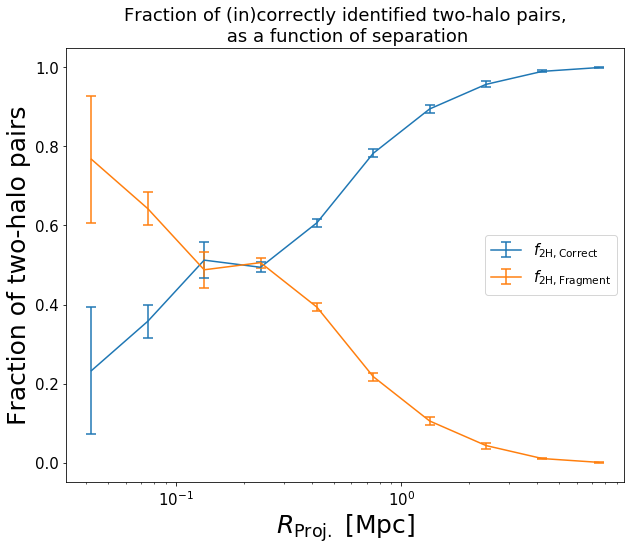

In [28]:
fig6 = plt.figure(figsize=(10,8))
ax = fig6.add_subplot(111)
ax.errorbar(
            10**(sample_collections[0].sample.corrfuncs['obs_diff_halo'].config.bins.edges[:-1]+0.125),
            np.mean([c.sample.wtd_f2h_correct for c in sample_collections],axis=0),
            np.std([c.sample.wtd_f2h_correct for c in sample_collections],axis=0),
            capsize=5,capthick=1.5
)
ax.errorbar(
            10**(sample_collections[0].sample.corrfuncs['obs_diff_halo'].config.bins.edges[:-1]+0.125),
            np.mean([c.sample.wtd_f2h_frag for c in sample_collections],axis=0),
            np.std([c.sample.wtd_f2h_frag for c in sample_collections],axis=0),
            capsize=5,capthick=1.5
)
ax.set_xscale('log')
ax.legend(('$f_{\\rm{2H,Correct}}$','$f_{\\rm{2H,Fragment}}$'))
ax.set_xlabel('$R_{\\rm{Proj.}}$ [Mpc]',fontsize=25)
ax.set_ylabel('Fraction of two-halo pairs',fontsize=25)
ax.set_title('Fraction of (in)correctly identified two-halo pairs,\n as a function of separation')

In [40]:
fig6.savefig('figures/fig6.png', bbox_inches = 'tight')

# Figure 7

<font size="1">
$\hat{w}_{\Delta}(R_p)=f_{2H,Correct}(R_p)\cdot w_{\Delta,2H}(R_p)+f_{2H,Fragment}(R_p)\cdot w_{\Delta,1H}(R_p),$
</font>

# Compute errorbars for corrected SDSS signal correctly!

In [37]:
#lg_corrected_signals = [ (c.sample.corrfuncs['obs_diff_halo_unwtd'].results -
#                          c.sample.f2h_frag*part.corrfuncs['true_same_halo_unwtd'].results)/c.sample.f2h_correct
#                         for c in sample_collections]

lg_corrected_signals = [ (c.sample.corrfuncs['obs_diff_halo'].results -
                          c.sample.wtd_f2h_frag*part.corrfuncs['true_same_halo'].results)/c.sample.wtd_f2h_correct
                         for c in sample_collections]

lg_CorrectedTwoHaloSignal = corrfunc('Delta_md',sample='dummy',pairs='dummy',weighted=True)
lg_CorrectedTwoHaloSignal.results = np.mean(lg_corrected_signals, axis=0)
lg_CorrectedTwoHaloSignal.stdev = np.std(lg_corrected_signals, axis=0)

/scratch/Documents/Conformity2019/env/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/scratch/Documents/Conformity2019/env/lib/python3.6/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [38]:
f2h_frag = np.mean([ c.sample.wtd_f2h_frag for c in sample_collections],axis=0)
f2h_correct = np.mean([ c.sample.wtd_f2h_correct for c in sample_collections],axis=0)

sdss_CorrectedTwoHaloSignal = corrfunc('Delta_md',sample='dummy',pairs='dummy',weighted=True)
sdss_CorrectedTwoHaloSignal.results = (sdss.corrfuncs['obs_diff_halo'].results-
                                        f2h_frag*sdss.corrfuncs['obs_same_halo'].results)/f2h_correct
#sdss_CorrectedTwoHaloSignal.errorbars = (sdss.corrfuncs['obs_diff_halo'].errorbars+
#                                         f2h_frag*sdss.corrfuncs['obs_same_halo'].errorbars)/f2h_correct

sdss_CorrectedTwoHaloSignal.errorbars = np.sqrt( 
                                        (np.array(sdss.corrfuncs['obs_diff_halo'].errorbars)**2 +
                                         f2h_frag**2*np.array(sdss.corrfuncs['obs_same_halo'].errorbars)**2)/f2h_correct**2
)

Text(0.5, 1.0, 'SDSS')

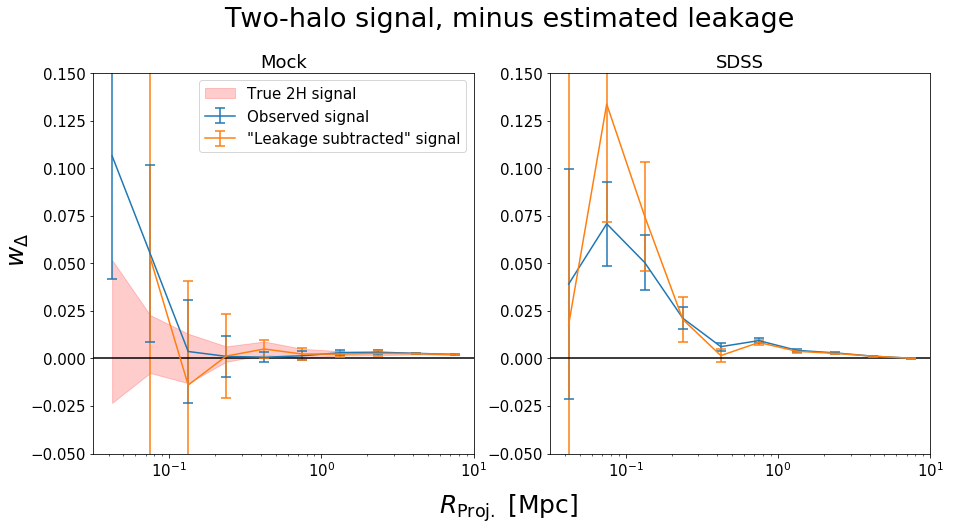

In [55]:
fig7 = plt.figure(figsize=(15,7))

pos = [0.1,0.1,0.82,0.86]

over = fig7.add_subplot(111)
over.set_position(pos)
for spine in over.spines.values():
    spine.set_color('none')
over.tick_params(color='none', labelcolor='none', top='off', bottom='off', left='off', right='off')
over.set_xlabel('$R_{\\rm{Proj.}}$ [Mpc]',fontsize=25)
over.set_ylabel('$w_{\\Delta}$',fontsize=25)
over.set_title('Two-halo signal, minus estimated leakage',fontsize=27)

ax = fig7.add_subplot(121)
lg_average_corrfuncs['true_diff_halo'].plot(ax,('fill_between','stdev'),
                                            color='r',alpha=0.2,label='True 2H signal')
AverageCfs['obs_diff_halo'].plot(ax,('errorbar','stdev'),
                                 capsize=5,capthick=1.5,label='Observed signal')
lg_CorrectedTwoHaloSignal.plot(ax,('errorbar','stdev'),
                               capsize=5,capthick=1.5,label='"Leakage subtracted" signal')

ax.set_xscale('log')
ax.hlines(0,10**-1.5,10**1.0)
ax.axis([10**-1.5,10**1,-0.05,0.15])
ax.set_title('Mock')
ax.legend()


ax = fig7.add_subplot(122)
sdss.corrfuncs['obs_diff_halo'].plot(ax,('errorbar','errorbars'),
                                     capsize=5,capthick=1.5,label='Observed signal')
sdss_CorrectedTwoHaloSignal.plot(ax,('errorbar','errorbars'),
                                 capsize=5,capthick=1.5,label='Corrected signal')
ax.set_xscale('log')
ax.hlines(0,10**-1.5,10**1.0)
ax.axis([10**-1.5,10**1,-0.05,0.15])
ax.set_title('SDSS')

In [44]:
10**np.mean([sdss_CorrectedTwoHaloSignal.config.bins.edges[:-1],sdss_CorrectedTwoHaloSignal.config.bins.edges[1:]],axis=0)

array([0.04216965, 0.07498942, 0.13335214, 0.23713737, 0.4216965 ,
       0.74989421, 1.33352143, 2.37137371, 4.21696503, 7.49894209])

In [48]:
np.set_printoptions(suppress=True)

In [50]:
sdss_CorrectedTwoHaloSignal.results

array([0.01760165, 0.13369076, 0.07461018, 0.02048268, 0.00146116,
       0.00834693, 0.00372906, 0.00260165, 0.00115945, 0.00006522])

In [56]:
fig7.savefig('figures/fig7.png', bbox_inches = 'tight')

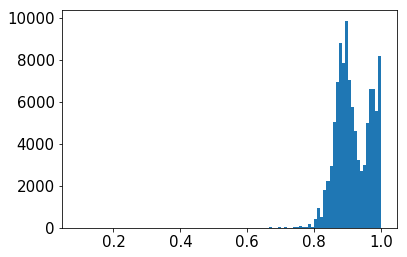

In [56]:
plt.hist(sdss.data['fgotmain'],bins=100);

In [62]:
max(299792.458*np.diff(sdss.pair_list.get('redshift'),axis=1))

array([499.99983248])

In [59]:
max(sdss.pair_list.separations)

10.026854534064313

In [63]:
sdss.count

106354

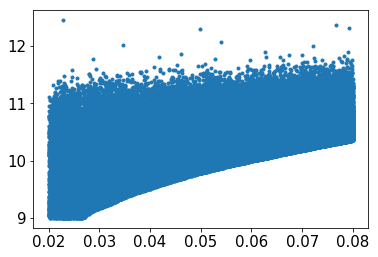

In [65]:
plt.plot(sdss.data['redshift'],sdss.data['StellarMass'],'.')

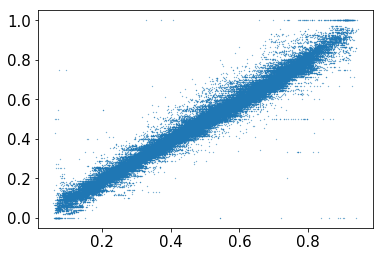

In [69]:
plt.plot(sdss.data['fq_md_old'],sdss.data['fq_md'],'.',markersize=0.5)

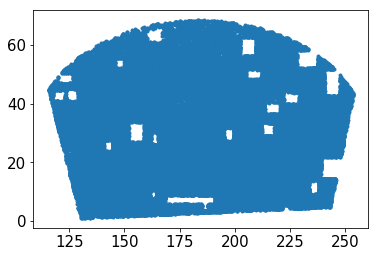

In [71]:
plt.plot(sdss.data['ra'],sdss.data['dec'],'.')